# Detecting change in urban extent

Digital Earth Africa data can be accessed, inspected, and analysed in a range of computing environments. This notebook demonstrates how to access data using the [odc-stac](https://odc-stac.readthedocs.io/en/latest/) software package. It provides guidance on configuration, plotting, and cloud masking.

Directly accessing Digital Earth Africa in an environment of choice offers advantages such as flexibly choosing the volume of compute resources required in a cloud environment, and the possibility of fusing Digital Earth Africa data with your own or other third party data. There are numerous environments in which this notebook and workflow can be run. This notebook was developed in [Sagemaker Studio Lab](https://studiolab.sagemaker.aws/) powered by AWS, which gives a similar computing environment to the Digital Earth Africa Sandbox. Alternative options include [Google Colab](https://colab.google/) or [installing Jupyter](https://jupyter.org/) and running it on a local device.

Both Colab and SageMaker have free tiers which are sufficient for running this notebook. For larger applications and upscaling, you might consider larger compute instances which can be purchased through cloud computing providers.

## Background

The rate at which cities and towns grow, or the urbanisation rate, is an important indicator of the sustainability of towns and cities. Rapid, unplanned urbanisation can result in poor social, economic, and environmental outcomes due to inadequate and overburdened infrastructure and services creating congestion, worsening air pollution, and leading to a shortage of adequate housing.

The first requirement for addressing the impacts of rapid urbanisation is to accurately and regularly monitor urban expansion in order to track urban development over time. Earth Observation datasets, such as those available through the Digital Earth Africa platform provide a cost-effective and accurate means of mapping the urban extent of cities.

The notebook runs through the following:
1. Load Landsat-8 & 9 annual geomedians data over the city/region of interest
2. Calculate the Enhanced Normalised Difference Impervious Surfaces Index (ENDISI)
3. Threshold the ENDISI plots to delineate urban extent
4. Compare the urban extent in the baseline year to the more recent urban extent

## Install and import packages

Depending on your environment, you may need to install some packages before importing them. The installation commands in the cell below are effective in Sagemaker Studio Lab (with kernel set to `sagemaker-distribution:Python`) and Google Colab.

If you are running the notebook for the first time, you can remove the `#`s and run the cell below. Often it is more aesthetic to add the `#`s back in after the cell has run because the outputs take a lot of space!

You may see some dependency resolver errors in the output, though this should not affect performance and did not during testing in Colab and SageMaker.

In [1]:
#!pip install pystac==1.10.0 --force-reinstall
#!pip install odc-stac
#!pip install osmnx
#!pip install pystac_client
#!pip install session-info
#!pip install odc-algo
#!pip install matplotlib

In [2]:
import matplotlib.pyplot as plt
import session_info
import odc.algo
import numpy as np

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

### Session Info

When working across different environments, it's helpful to display the software 'image' under which the script was developed. The cell below uses the `session_info` package to show package and Python versions used. This could be helpful if you experience bugs or software conflights when applying this script as you can refer to the package and Python versions below.

In [3]:
session_info.show()

/usr/local/lib/python3.11/dist-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


## Configure Landsat Geomedians

To calculate change in urban extent, we'll load Landsat-8 & 9 Geomedians.. To do this, we have to set the data configuration as per the cell below. The configuration is set as a dictionary object (`dict`) in Python.

We can use the [product definition](https://explorer.digitalearth.africa/products/gm_ls8_ls9_annual#definition-doc) on Digital Earth Africa explorer to help build the dictionary.

In [4]:
gm_ls8_ls9_config = {
    "gm_ls8_ls9_annual": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
        },
        "aliases": {
            "blue": "SR_B2",
            "green": "SR_B3",
            "red": "SR_B4",
            "swir_1": "SR_B6",
            "swir_2": "SR_B7"
        },
    },
   "gm_ls8_annual": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
        },
        "aliases": {
            "blue": "SR_B2",
            "green": "SR_B3",
            "red": "SR_B4",
            "swir_1": "SR_B6",
            "swir_2": "SR_B7"
        },
    },
}

### Set AWS endpoint

The `configure_rio` command sets the AWS endpoint we need to request the data from. The [location information](https://explorer.digitalearth.africa/products/s2_l2a_c1#location) can help us identify the correct AWS endpoint. There's also information on the AWS specifications in the [direct access documentation](https://docs.digitalearthafrica.org/en/latest/platform_tools/direct_access.html).

In [5]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

### Open the STAC catalog

Explorer provides the STAC catalog we use the identify the data we're requesting.

There's also information on the Digital Earth Africa STAC endpoint in the [direct access documentation](https://docs.digitalearthafrica.org/en/latest/platform_tools/direct_access.html).

In [6]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

## Set area and period of interest

Similar to working with any other spatiotemporal data, we set our area of interest with a bounding box and period of interest with a start and end date. In this case, we're looking at the city of Juba in South Sudan.

In [7]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [31.5, 4.75, 31.7, 4.95]

# Set a start and end date
start_date = "2014"
end_date = "2024"

# Set the STAC collections
collections = ["gm_ls8_annual", "gm_ls8_ls9_annual"]

baseline_year = 2014
analysis_year = 2022

Build a STAC query based on the area and period of interest. This cell returns the number of datasets that match our STAC query. Note that these may represent different times, or they may be datasets that overlap in space (if there are multiple matches).

In [8]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 10 datasets


Next, we set the parameters for data loading such as the coordinate reference system (crs) and bands we want to load using the [`stac_load` function](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html).

This returns an `xarray` object which makes it easy to deal with numerous dimensions.

In [9]:
ds = stac_load(
    items,
    bands=('swir_1','swir_2','blue','green','red'),
    crs='EPSG:6933',
    chunks={},
    groupby="solar_day",
    stac_cfg=gm_ls8_ls9_config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 55MB
Dimensions:      (y: 849, x: 644, time: 10)
Coordinates:
  * y            (y) float64 7kB 6.307e+05 6.307e+05 ... 6.053e+05 6.053e+05
  * x            (x) float64 5kB 3.039e+06 3.039e+06 ... 3.059e+06 3.059e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 80B 2014-01-01 2015-01-01 ... 2023-01-01
Data variables:
    swir_1       (time, y, x) uint16 11MB dask.array<chunksize=(1, 849, 644), meta=np.ndarray>
    swir_2       (time, y, x) uint16 11MB dask.array<chunksize=(1, 849, 644), meta=np.ndarray>
    blue         (time, y, x) uint16 11MB dask.array<chunksize=(1, 849, 644), meta=np.ndarray>
    green        (time, y, x) uint16 11MB dask.array<chunksize=(1, 849, 644), meta=np.ndarray>
    red          (time, y, x) uint16 11MB dask.array<chunksize=(1, 849, 644), meta=np.ndarray>

## View the geomedian

The cells below plot the geomedian in 'true-colour' using the red, green, and blue bands.

In [10]:
quants = np.quantile(ds.to_array(), 0.01), np.quantile(ds.to_array(), 0.99) # set quantiles

bands = ['red','green','blue']
ds_im = ds[bands].isel(time=0).squeeze().to_array().transpose('y','x','variable').clip(quants[0], quants[1])/np.max(
    ds[bands].isel(time=0).squeeze().to_array().transpose('y','x','variable').clip(quants[0], quants[1]))

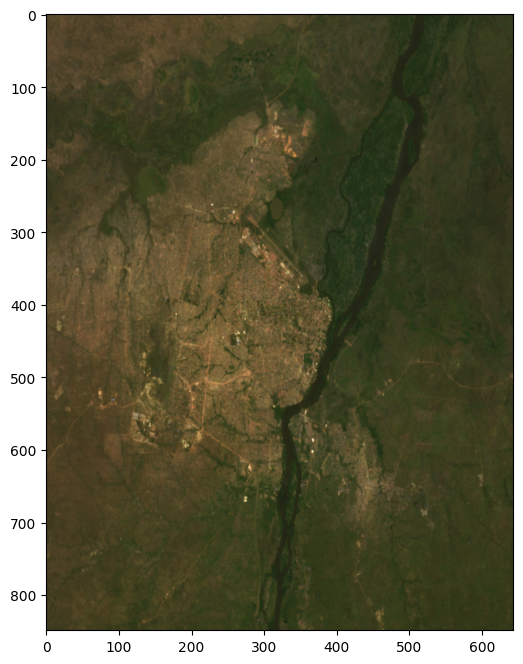

In [11]:
plt.figure(figsize = (16,8))
plt.imshow(ds_im)

We group the time series of geomedians by year and select those years we're interested in as a baseline and analysis year. This makes the dataset `ds` easier to deal with.

In [12]:
#groupby year so the time dimension is converted to year
# the .mean() doesn't do anything here
ds=ds.groupby('time.year').mean()

ds = ds.sel(year=[baseline_year, analysis_year])

## Calculate ENDISI

The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a recently developed urbanisation proxy that has been shown to work well in a variety of environments ([Chen et al. 2020](https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1820383)) . Like all normalised difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
{swir_diff} = \frac{{SWIR1}}{{SWIR2}}
\end{aligned}
$$

$$
\begin{aligned}
{alpha} = \frac{2 * {mean(BLUE)}}{{mean(swir_diff) + mean(MNDWI}^2)}
\end{aligned}
$$

$$
\begin{aligned}
{ENDISI} = \frac{{BLUE} - {alpha}*({swir_diff} + {MNDWI}^2)}
{{BLUE} + {alpha}*({swir_diff} + {MNDWI}^2)}
\end{aligned}
$$

The code in the cells below is adapted from the [Digital Earth Africa Tools band indices](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/main/Tools/deafrica_tools/bandindices.py) module, noting that we are using Landsat data in this instance.

In [13]:
sr_max = 10000
# Dictionary mapping full data names to simpler alias names
bandnames_dict = {
    "nir_1": "nir",
    "B02": "blue",
    "B03": "green",
    "B04": "red",
    "B05": "red_edge_1",
    "B06": "red_edge_2",
    "B07": "red_edge_3",
    "B08": "nir",
    "B11": "swir_1",
    "B12": "swir_2",
}

# Rename bands in dataset to use simple names (e.g. 'red')
bands_to_rename = {a: b for a, b in bandnames_dict.items() if a in ds.variables}

# Enhanced Normalised Difference Impervious Surfaces Index, Chen et al. 2019
def mndwi(ds):
    return (ds.green - ds.swir_1) / (ds.green + ds.swir_1)

def swir_diff(ds):
    return ds.swir_1 / ds.swir_2

def alpha(ds):
    return (2 * (np.mean(ds.blue))) / (np.mean(swir_diff(ds)) + np.mean(mndwi(ds) ** 2))

def ENDISI(ds):
    m = mndwi(ds)
    s = swir_diff(ds)
    a = alpha(ds)
    return (ds.blue - (a) * (s + m**2)) / (ds.blue + (a) * (s + m**2))

In [14]:
ds["ENDISI"] = ENDISI(ds)

Let's plot the ENDISI images so we can see if the urban areas are distinguishable.

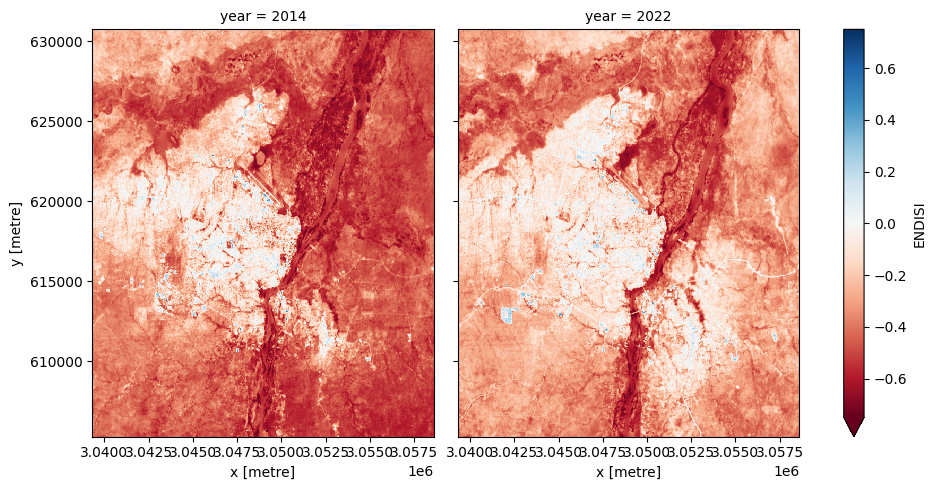

In [15]:
ds.ENDISI.plot(
    col='year',
    vmin=-.75,
    vmax=0.75,
    cmap='RdBu',
    figsize=(10, 5),
    robust=True
);

And now plot the histogram of all the pixels in the ENDISI array.

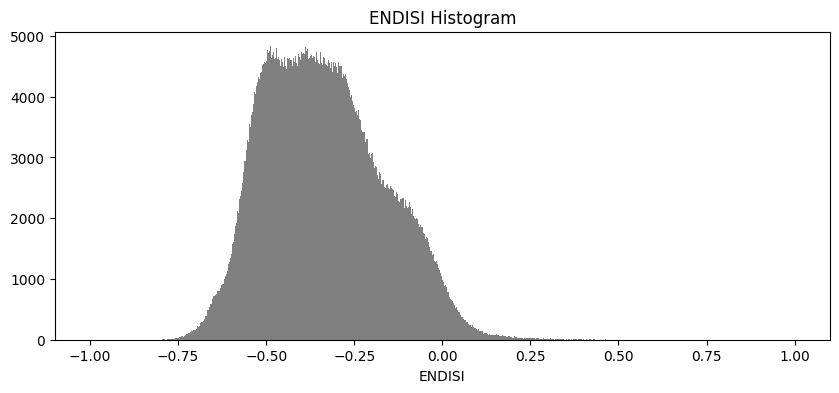

In [16]:
ds.ENDISI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram');

## Calculate urban extent

To define the urban extent, we need to threshold the ENDISI arrays. Values above this threshold will be labelled as 'Urban' while values below the trhehsold will be excluded from the urban extent.  We can determine this threshold a number of ways (inluding by simply manually definining it e.g. `threshold=-0.1`).  Below, we use the [Otsu method](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html) to automatically threshold the image.  

Firstly, we need to fill any `NaN` values we have in the dataset with the mean of the dataset, otherwise the otsu threshold function will complain:

In [17]:
ds['ENDISI'] = ds.ENDISI.fillna(ds.ENDISI.mean().values)

In [18]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(ds.ENDISI.values)
print(round(threshold, 2))

-0.32


### Apply the threshold

We apply the threshold and plot both years side-by-side.

In [19]:
urban_area = ((ds.ENDISI > threshold) & (ds.ENDISI < 0.8)).astype(int) # remove water < 0.8

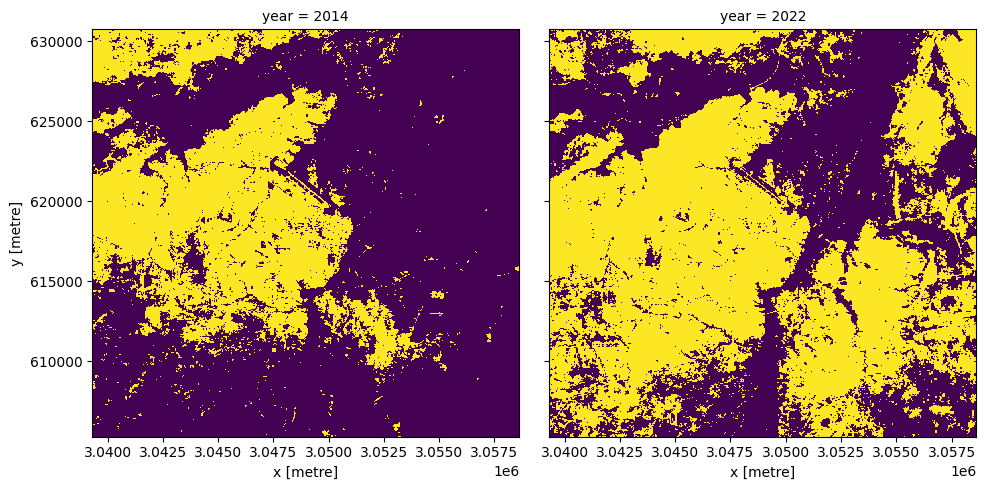

In [20]:
urban_area.plot(
    col='year',
    figsize=(10, 5),
    robust=True,
    add_colorbar=False
);

## Plotting the change in urban extent
We can convert the data above into a total area for each year, then plot a bar graph.

Urban extent in 2014: 143.958 km2
Urban extent in 2022: 277.641 km2


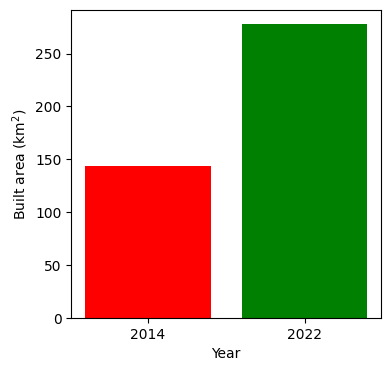

In [21]:
pixel_length = 30  # Landsat resolution in metres
area_per_pixel = pixel_length**2 / 1000**2

urban_area_km2 = urban_area.sum(dim=['x', 'y']) * area_per_pixel

# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1],
        urban_area_km2,
        tick_label=urban_area_km2.year,
        width = 0.8,
        color=['red', 'green']
       )
axes.set_xlabel("Year")
axes.set_ylabel("Built area (km$^2$)");

for y in urban_area_km2.year.values:
    print('Urban extent in '+str(y)+": "+str(round(float(urban_area_km2.sel(year=y).values),3))+' km2')

## Urban growth hotspots

If we subtract the ENDISI of the baseline year from the analysis year, we can highlight regions where urban growth is occurring.

In this plot, we can see areas that have seen significant change, highlighting regions of urbanisation.

In [22]:
# Calculate the change between the years
urban_change = urban_area.sel(
    year=analysis_year) - urban_area.sel(year=baseline_year)

urban_growth = urban_change.where(urban_change == 1)
urban_decline = urban_change.where(urban_change == -1)

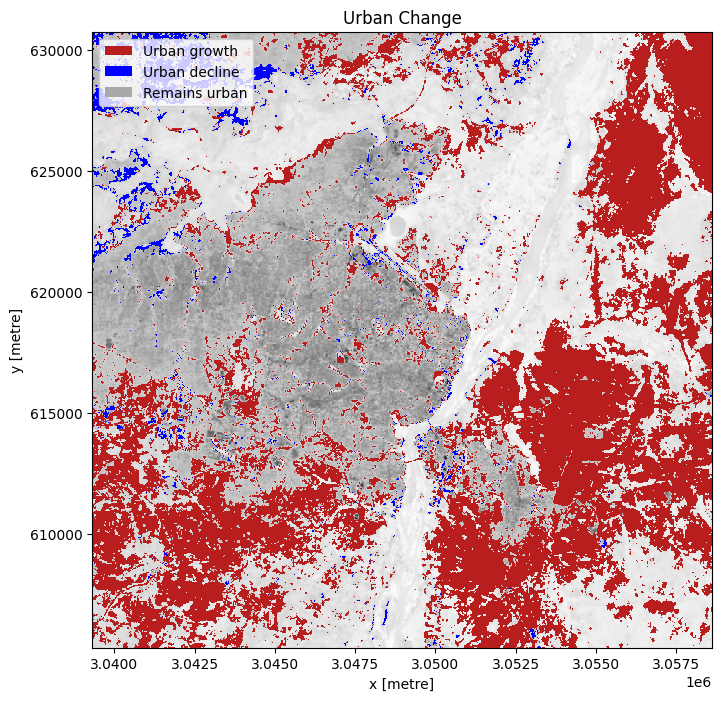

In [23]:
urban_appeared = '#b91e1e'
urban_disappeared = 'Blue'

# Plot urban extent from first year in grey as a background
plot = ds.ENDISI.sel(year=baseline_year).plot(size=8,
                                                      aspect=urban_area.y.size /
                                                      urban_area.y.size,
                                               cmap='Greys',
                                               add_colorbar=False)

# add urban growth and decline to the plot
urban_growth.plot(ax=plot.axes,
                  cmap=ListedColormap([urban_appeared]),
                  add_colorbar=False,
                  add_labels=False,
                  )
urban_decline.plot(ax=plot.axes,
                   cmap=ListedColormap([urban_disappeared]),
                   add_colorbar=False,
                   add_labels=False
                   )
# Add the legend
plot.axes.legend(
    [
        Patch(facecolor=urban_appeared),
        Patch(facecolor=urban_disappeared),
        Patch(facecolor='darkgrey'),
        Patch(facecolor='white')
    ],
    ['Urban growth', 'Urban decline', 'Remains urban'],
    loc='upper left'
)

plt.title('Urban Change');

## Conclusion and next steps

This notebook has demonstrating loading Digital Earth Africa geomedian data for urban change detection. You could adapt these processes to Digital Earth Africa products and services of your interest.

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last Tested:**

In [24]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-04-29'